<a href="https://colab.research.google.com/github/nishahebbalae/OpenAI/blob/main/AssistantWithFiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install openai --upgrade


In [ ]:
#**TASK: Connect to OpenAI via the client call**

from google.colab import userdata
import openai
from openai import OpenAI

api_key = userdata.get('OPENAI_API_KEY')
api_key

client = OpenAI(
    api_key=api_key,
)

In [ ]:
##**TASK: Upload the file "exercise_sales_data.csv" to your OpenAI File Set and mark down its file.id**

import os
files_to_upload = list(filter(lambda x: x.endswith('csv'), os.listdir()))
if files_to_upload == []:
  print("No csv file to upload")
  exit()

def upload_assistant_file(filename):
    file = client.files.create(
      file=open(filename, "rb"),
      purpose='assistants'
    )
    print(file.id)

#Remove duplicate files
for file in client.files.list():
    if file.filename in files_to_upload:
        client.files.delete(file_id=file.id)

for filename in files_to_upload:
  upload_assistant_file(filename)

for file in client.files.list():
    print('File {} with id{}'.format(file.filename, file.id))

file-gWZANOkaRjqahBqGhOIQbPFB
File exercise_sales_data.csv with idfile-gWZANOkaRjqahBqGhOIQbPFB
File ad9cd74a-aa6f-49ee-aa76-d2689acbdc1b with idfile-2JgcG1hNsWZze6nka5UuS5Rm


In [ ]:
##**TASK: Create the assistant with both retrieval tool and code_interpreter tool.**

assistant = client.beta.assistants.create(
    name="Exercise Sales Data Assistant",
    instructions="You use Python code to interpret sales data from the csv file",
    tools=[{"type": "code_interpreter"}, {"type": "retrieval"}],
    model="gpt-3.5-turbo"
)
assistant.id

'asst_Hjm7dEMFuYjRHcTiJEgHWiWW'

In [ ]:
##**TASK: Create a new thread.**

thread = client.beta.threads.create()
thread.id

'thread_yUtEbXKCvZwJ0zUKJy3Zwm77'

In [ ]:
##**TASK: Create a message asking the model to create a bar plot of the total sum of Purchase Price expenditure per year.
## Remember to mention the file.id in the file_ids parameter list.**

content = """  create a bar plot of the total sum of Purchase Price expenditure per year.
"""

message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content=content,
    file_ids=[file.id],

)

message.id

'msg_TMekb51VKL7hGnybuW4HsTt2'

In [ ]:
##**TASK: Create a run to run the message on the thread.
## Optional: If the model complains about not having access to the file, try adding the file.id in your instructions prompt for that specific run.**

#Steps are:
#Create the run
#Wait on the run
#retrieve the messages
#display the messages in reverse order, last msg is always at index 0

import time

def wait_on_run(run, thread):
    '''
    Simple function that waits on the run of a particular thread.
    Returns the run once the thread has been run.
    '''
    while run.status == "queued" or run.status == "in_progress":
        run = client.beta.threads.runs.retrieve(
            thread_id=thread.id,
            run_id=run.id,
        )
        time.sleep(0.5)
    return run

def runMessageThread(message_id):
  run = client.beta.threads.runs.create(
      thread_id=thread.id,
      assistant_id=assistant.id,
  )
  # Wait for completion
  wait_on_run(run, thread)

runMessageThread(message_id = message.id)

In [ ]:
#Print the messages returned by the run

messages = client.beta.threads.messages.list(
    thread_id=thread.id, order="asc",
)

for thread_message in messages:
  content = thread_message.content[0]
  print(thread_message.id, content)
  print('\n')
  if isinstance(content, openai.types.beta.threads.image_file_content_block.ImageFileContentBlock):
    print("Image file generated!")
    image_msg_id = thread_message.id
    image_msg_content = content
    print(thread_message.id, content, type(content))


msg_TMekb51VKL7hGnybuW4HsTt2 TextContentBlock(text=Text(annotations=[], value='  create a bar plot of the total sum of Purchase Price expenditure per year.\n'), type='text')


msg_BcF8wNEaOioVNMvgn2qOZtYE TextContentBlock(text=Text(annotations=[], value="I will start by loading the data from the uploaded file to understand its structure and extract the necessary information for creating the bar plot of the total sum of Purchase Price expenditure per year. Let's begin by loading the data."), type='text')


msg_pOeHs2khjPPdPDNkDIqk9UrN TextContentBlock(text=Text(annotations=[], value="It appears that there was an issue with decoding the file using the default UTF-8 encoding. We can try reading the file with a different encoding to see if that resolves the problem. Let's try reading the file again using a different encoding."), type='text')


msg_kN0Dou4xtyoGzZGygYXAnCWf TextContentBlock(text=Text(annotations=[], value="It seems like there was an error tokenizing the data. The error sugge

In [ ]:
#Message with image content. Get the image content and save it to file
message = client.beta.threads.messages.retrieve(
  message_id=image_msg_id,
  thread_id=thread.id,
)

image_file_id = image_msg_content.image_file.file_id

image = client.files.content(image_file_id)

# Write the bytes to a file
with open('PurchasePricePlot.png', 'wb') as file:
    file.write(image.content)


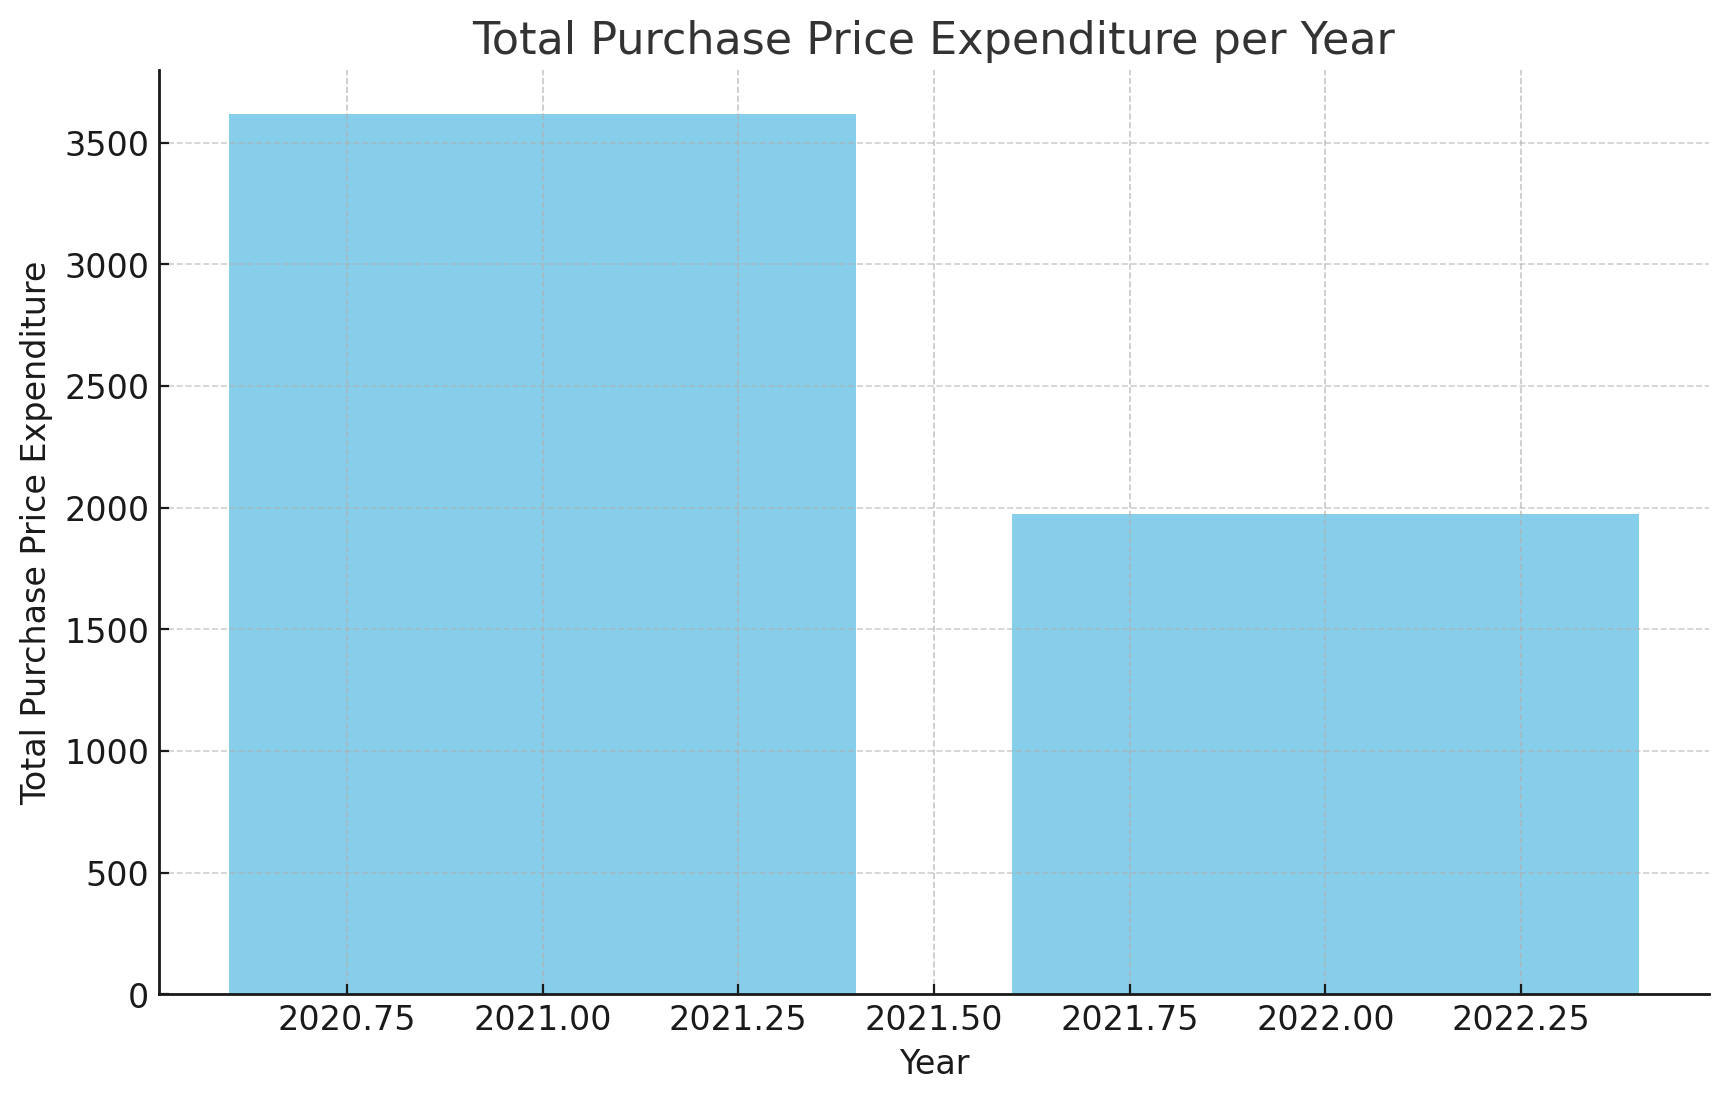

In [ ]:
from IPython.display import Image

# Display the image
Image(filename='PurchasePricePlot.png')


In [ ]:
# Delete all the assistants and files that were created

my_assistants = client.beta.assistants.list(
    order="desc",
    limit="20",
)
response = client.beta.assistants.delete(my_assistants.data[0].id)
print(response)

for file in client.files.list():
    client.files.delete(file.id)

AssistantDeleted(id='asst_MTkSsH96Qlb9EMYaqmLynhCd', deleted=True, object='assistant.deleted')
